The dataset contains 1250 headlines from a variety of news publications. Each is given a rating between 0 and 100 for six emotion categories. 

Since ninety eight percent of the dataset has at least two emotions with non-zero ratings, it makes sense to treat this task as a multilabel classification probelm. The model should be able to make a prediction (present or not present) for each emotion label. 

In this notebook, I use the skmultilearn package's Chain Classifier with a Support Vector Classifier and a Recurrent Neural Network to make predictions and compare the results.

The best performing model for this task was ...


In [255]:
# basics
import pandas as pd
import numpy as np
import itertools

# vectorizer, classifiers, and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix, jaccard_score, hamming_loss, log_loss
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.multiclass import OneVsRestClassifier

# rnn
import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# custom functions, class to import and process data
from get_labeled_dfs import *
from process_text import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [256]:
# use custom function to get the corpus df and labels 
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [257]:
# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [165]:
# after processing, the text in the corpus df is all lower case, free of punctuation, 
# numbers, and special characters, and lemmatized
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [166]:
# The emotion df contains ratings for each emotion, the max rating, and label columns 
# for each emotion with a 1 indicating that the emotion is present (it has a non-zero 
# rating) or a 0 indicating that it is not.  
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


## Prepare Multilabel Classification Evaluation

I've compiled my evaluation metrics in two functions. One is for evaluating how a model performed with respect to each individual emotion label. The other is a set of summary scores useful for comparing a model's overall performace with other models.

### Evaluating preformance on individual emotion labels

I use confusion matrices to display predicted labels vs. actual labels.

To compare performace on individual labels, I use accuracy, precision, recall, and f1 scores.

* Accuracy score tells us the ratio of correct predictions to total predictions 

* Precision score tells us the ratio of correct predictions to total predictions of the target class 

* Recall score tells us the ratio of correct predictions to the total true cases of the taget class

* F1 is a weighted average of precision and recall



In [167]:
def label_confusion_matrices(lst, df, RNN=False):
    
    '''A function that creates confusion matrices and calculates accuracy, precision, 
    recall, and f1 for each individual label'''
    
    plt.figure(figsize=(10,15))
    subplot_num = 1

    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(3,2,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')

        

To evaluate a model's performance on all labels, I compare jaccard similarity, hamming loss, and f1 macro scores.

* Jaccard Similarity is the ratio of correct labels to total predictions.

* Hamming Loss is the ratio of incorrect labels to total predictions. 

* F1 Macro is an mean of f1 scores (see above) for all labels.

Note that Jaccard Similarity and Hamming loss both count the correct or incorrect labels for each individual label and add them together. I use these metrics rather than ones requiring a perfect match across all labels because I'm interesting in knowing whether a model can predict subsets of the correct labels at a higher rate than others. In order to do so, I need metrics that do not treat a prediction that gets five out of six labels correct the same as one that gets zero out of six correct.


In [168]:
def suite_of_scores(y_true, y_pred):
    
    '''A function that calculates jaccard similarity, hamming loss, f1 macro, 
    and log loss to assess the model's overall performance'''
    
    jaccard_score_samples = jaccard_score(y_true, y_pred, average='samples')
    hamming_loss_score = hamming_loss(y_true, y_pred)
    f1_macro_score = f1_score(y_true, y_pred, average='macro')
    
    print('jaccard score average:', round(jaccard_score_samples, 3))
    print('hamming loss:', round(hamming_loss_score, 3))
    print('f1 macro:', round(f1_macro_score, 3))
    

## TF-IDF

The data needs to be transformed into a numeric format before it can be used to train a model. 

One option is to use a count vectorizer. By this method, each word in the vocabulary is a column and each sentence is a row. The sentence is represented by a count for each word that is present. All other words have zeros.

As an example, I'll use the opening lines of Dickens's *Tale of Two Cities*: "It was the best of times. It was the worst of times." 

| it | was | the | best | of | times | worst | 
|----|-----|-----|------|----|-------|-------|
|1   |1    |1    |1     |1   |1      |0      |
|1   |1    |1    |0     |1   |1      |1      |


Another option is to use term frequency - inverse document frequency (TF-IDF). TF-IDF is a representation of how import a word is in distinguishing a document so that words that appear across all documents are treated as less significant. The higher the score, the more significant the word.

...

In [271]:
# first split the data into separate training and testing sets
X_train, X_test, y_train, y_test = train_test_split(corpus_df['text'], emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], random_state=3)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_test


<313x2332 sparse matrix of type '<class 'numpy.float64'>'
	with 1138 stored elements in Compressed Sparse Row format>

## One Versus Rest Model

An important consideration in choosing a multilabel prediction model is whether the labels are independent or correlated. There is some moderate correlation between the labels in my dataset.

*Insert pic*

For comparison, I tested methods that treats labels as independent and methods that allows for label correlations. In this notebook, I include:

* One Versus Rest Classifier

A One Versus Rest classifier trains a separate model for each label in the dataset. Each model's predictions are independent of the other models' predictions.

For this model, I used a logistic regression classifier.

* Correlated: Chain Classifier

A Chain Classifier trains a model for each label in the dataset, but each model's predictions are transferred to the next model, so the probabistic relationships between labels are taken into account.

For this model, I used a linear support vector classifier.


In [171]:
lr = LogisticRegression(C=1e10, class_weight='balanced')

ovr = OneVsRestClassifier(lr)

ovr.fit(tf_idf_X_train, y_train)
ovr_train_preds = ovr.predict(tf_idf_X_train)
ovr_test_preds = ovr.predict(tf_idf_X_test)

In [172]:
ovr_preds_df = pd.DataFrame(ovr_test_preds, columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
ovr_preds_df = pd.concat([ovr_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.4981949458483754
anger_label precision: 0.8117647058823529
anger_label recall 0.7931034482758621
anger_label f1 0.8023255813953488


disgust_label accuracy: 0.33203125
disgust_label precision: 0.6390977443609023
disgust_label recall 0.5985915492957746
disgust_label f1 0.6181818181818183


fear_label accuracy: 0.6389891696750902
fear_label precision: 0.8009049773755657
fear_label recall 0.8309859154929577
fear_label f1 0.815668202764977


joy_label accuracy: 0.5384615384615384
joy_label precision: 0.7368421052631579
joy_label recall 0.7253886010362695
joy_label f1 0.7310704960835509


sadness_label accuracy: 0.6819787985865724
sadness_label precision: 0.8109243697478992
sadness_label recall 0.8654708520179372
sadness_label f1 0.8373101952277657


surprise_label accuracy: 0.8900343642611683
surprise_label precision: 0.9184397163120568
surprise_label recall 0.9217081850533808
surprise_label f1 0.9200710479573712




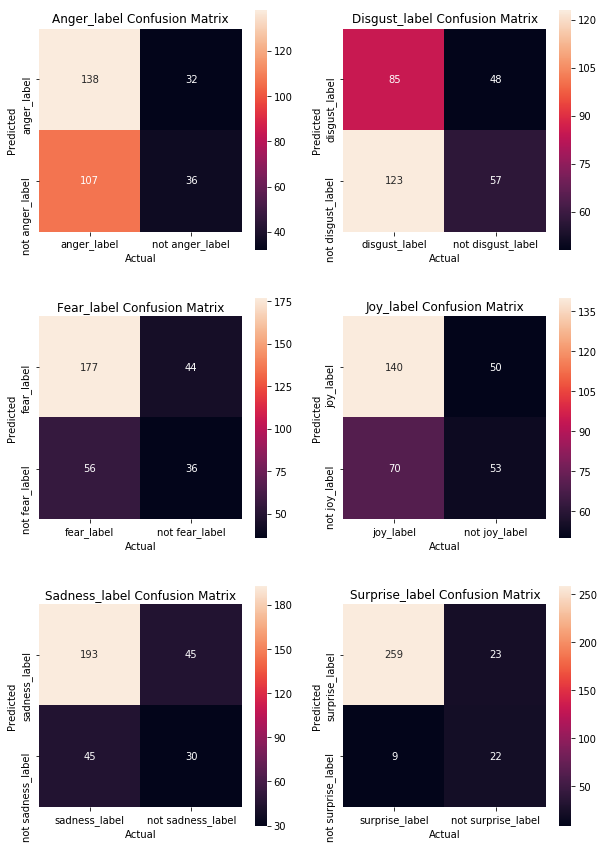

In [173]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], ovr_preds_df)


In [174]:
suite_of_scores(y_test, ovr_test_preds)


jaccard score average: 0.685
hamming loss: 0.253
f1 macro: 0.787


## Classifier Chain

In [175]:
svc = LinearSVC(class_weight='balanced')

perms = list(itertools.permutations([0,1,2,3,4,5]))

chains = [ClassifierChain(svc, order=perms[i]) for i in range(720)]

results_jaccard = []
preds = []
for chain in chains:
    chain.fit(tf_idf_X_train, y_train)
    test_preds = chain.predict(tf_idf_X_test)
    preds.append(test_preds)
    results_jaccard.append(jaccard_score(y_test, test_preds, average='samples'))


In [179]:
cc_test_preds = preds[results_jaccard.index(max(results_jaccard))]
max(results_jaccard)

0.7005857294994676

In [180]:
cc_preds_df = pd.DataFrame(cc_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
cc_preds_df = pd.concat([cc_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.49454545454545457
anger_label precision: 0.8143712574850299
anger_label recall 0.7816091954022989
anger_label f1 0.7976539589442815


disgust_label accuracy: 0.3619402985074627
disgust_label precision: 0.697841726618705
disgust_label recall 0.6830985915492958
disgust_label f1 0.6903914590747331


fear_label accuracy: 0.6282527881040892
fear_label precision: 0.8492462311557789
fear_label recall 0.7934272300469484
fear_label f1 0.8203883495145631


joy_label accuracy: 0.5419847328244275
joy_label precision: 0.7513227513227513
joy_label recall 0.7357512953367875
joy_label f1 0.743455497382199


sadness_label accuracy: 0.660377358490566
sadness_label precision: 0.8620689655172413
sadness_label recall 0.7847533632286996
sadness_label f1 0.8215962441314555


surprise_label accuracy: 0.8888888888888888
surprise_label precision: 0.9175627240143369
surprise_label recall 0.9110320284697508
surprise_label f1 0.9142857142857143




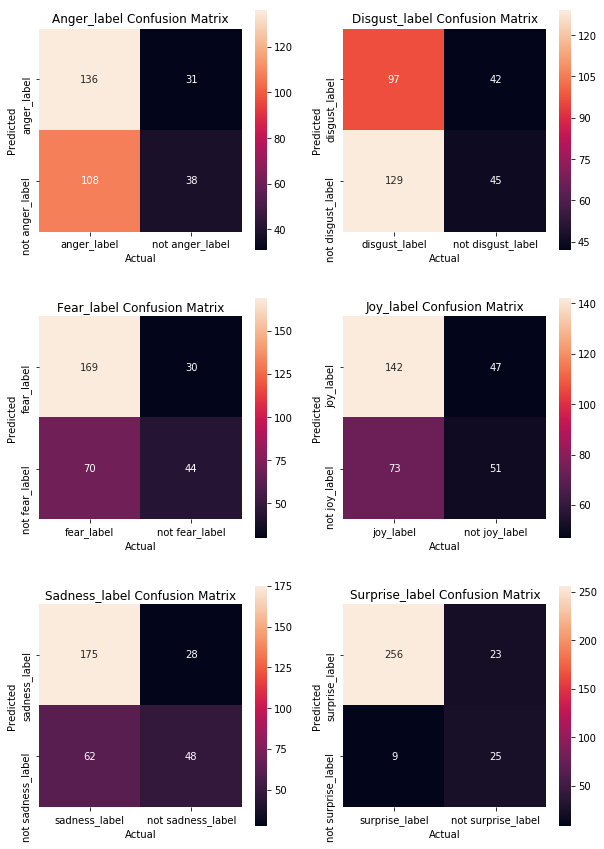

In [181]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], cc_preds_df)



In [182]:
suite_of_scores(y_test, cc_test_preds.toarray())


jaccard score average: 0.701
hamming loss: 0.241
f1 macro: 0.798


In [277]:
new = pd.DataFrame({"text":['meuller on russian election interference theyre doing it as we sit here', 
                                             'justice ginsburg i am very much alive',
                                             'photo of mother pleading with mexican soldier draws attention to migrant patrol',
                                             'how a perfect storm cut off water from this colorado town',
                                             'a requiem for audiogalaxy the digital wild wests best outlaw store',
                                             'rapper meek mill is granted retrial after years long legal fight',
                                             'how to help your anxious partner and yourself',
                                             'travelling together 7 tips to help keep the peace']})
processor = Process_Text_Data()
processor.transform(new)
tf_idf_new = vectorizer.transform(new)

best_chain = chains[results_jaccard.index(max(results_jaccard))]
best_chain.fit(tf_idf_X_train, y_train)
best_chain.predict(tf_idf_new).toarray()

array([[0., 0., 0., 1., 0., 1.]])

## RNN for Multilabel Classification

In [183]:
# use custom function to get the corpus df and labels 
corpus_df_RNN, _, _ = get_labeled_dfs()

# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df_RNN, RNN=True)


In [184]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df_RNN['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)
            

In [185]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(corpus_df_RNN['text']))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df_RNN['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=15, padding='post')


In [186]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]
        

In [204]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], test_size=0.25, random_state=10)

# labels multihot encoded
y_train_multihot = y_train.values
y_test_multihot = y_test.values


In [245]:
model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train_multihot,
                    epochs=30,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 8, 1: 1}, {0: 10, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test_multihot))

Train on 937 samples, validate on 313 samples
Epoch 1/30
937/937 [==============================] - 7s 7ms/step - loss: 0.6778 - acc: 0.6242 - val_loss: 0.7800 - val_acc: 0.6464
Epoch 2/30
937/937 [==============================] - 1s 632us/step - loss: 0.5233 - acc: 0.7407 - val_loss: 0.5796 - val_acc: 0.7082
Epoch 3/30
937/937 [==============================] - 1s 803us/step - loss: 0.4601 - acc: 0.7944 - val_loss: 0.5965 - val_acc: 0.7290
Epoch 4/30
937/937 [==============================] - 1s 617us/step - loss: 0.4005 - acc: 0.8294 - val_loss: 0.5667 - val_acc: 0.7396
Epoch 5/30
937/937 [==============================] - 1s 643us/step - loss: 0.3574 - acc: 0.8565 - val_loss: 0.5561 - val_acc: 0.7588
Epoch 6/30
937/937 [==============================] - 1s 626us/step - loss: 0.3120 - acc: 0.8815 - val_loss: 0.6143 - val_acc: 0.7231
Epoch 7/30
937/937 [==============================] - 1s 543us/step - loss: 0.2741 - acc: 0.9050 - val_loss: 0.5965 - val_acc: 0.7439
Epoch 8/30
937/937

313/313 [==============================] - 0s 317us/step


[0.5615495953696985, 0.7641107489506658]

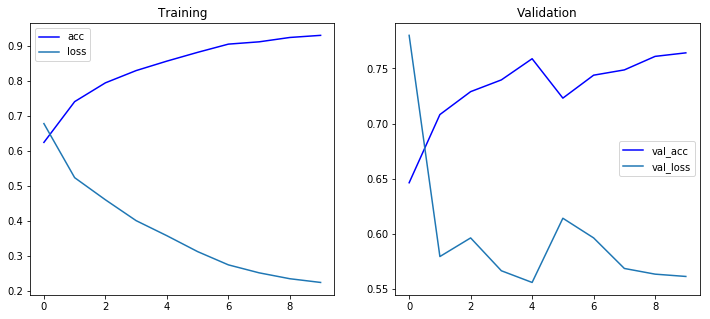

In [246]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')
plt.title("Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.title("Validation")
plt.legend()

model.evaluate(X_test, y_test_multihot)


In [247]:
# model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds_df = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_surprise":RNN_preds[:,5], "anger":y_test_multihot[:,0], "disgust":y_test_multihot[:,1], "fear": y_test_multihot[:,2], "joy": y_test_multihot[:,3], "sadness": y_test_multihot[:,4], "surprise": y_test_multihot[:,5]})


anger accuracy: 0.43272727272727274
anger precision: 0.7828947368421053
anger recall 0.7579617834394905
anger f1 0.7702265372168284


disgust accuracy: 0.323943661971831
disgust precision: 0.6433566433566433
disgust recall 0.7603305785123967
disgust f1 0.6969696969696969


fear accuracy: 0.5804195804195804
fear precision: 0.7757009345794392
fear recall 0.8601036269430051
fear f1 0.8157248157248156


joy accuracy: 0.569811320754717
joy precision: 0.7905759162303665
joy recall 0.7587939698492462
joy f1 0.7743589743589743


sadness accuracy: 0.6285714285714286
sadness precision: 0.8262910798122066
sadness recall 0.8421052631578947
sadness f1 0.8341232227488152


surprise accuracy: 0.8754448398576512
surprise precision: 0.9010989010989011
surprise recall 0.8848920863309353
surprise f1 0.8929219600725953




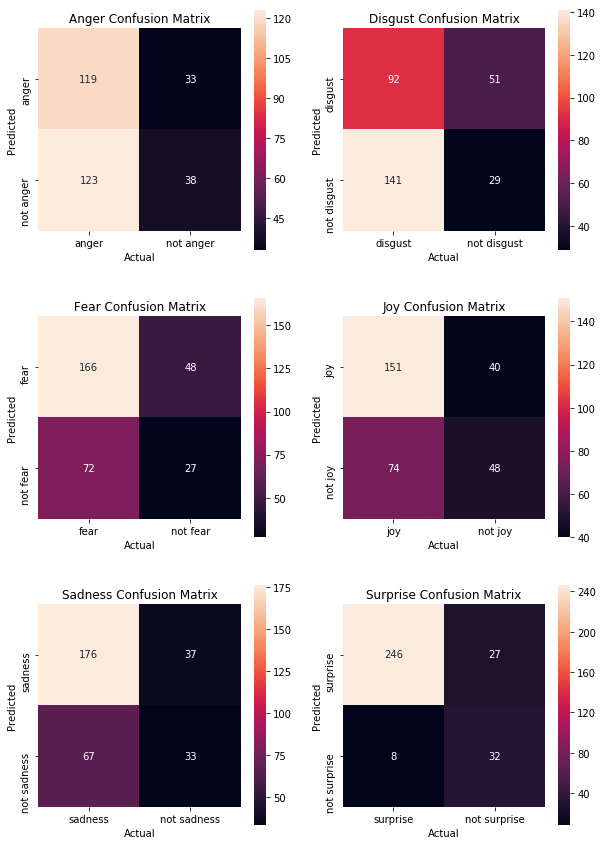

In [248]:
label_confusion_matrices(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], RNN_preds_df, RNN=True)

In [249]:
suite_of_scores(y_test, RNN_preds>.5)


jaccard score average: 0.707
hamming loss: 0.236
f1 macro: 0.797


## Predict something new

In [250]:
new_sequence = tokenizer.texts_to_sequences(['what a great story about happy people having fun !', 'unbelievable news about that sports team that lost tragically'])
padded_new = sequence.pad_sequences(new_sequence, maxlen=15, padding='post')

model.predict(padded_new)>.5

array([[False, False, False,  True,  True,  True],
       [ True,  True,  True, False,  True,  True]])

In [251]:
# NPR
new_sequence = tokenizer.texts_to_sequences(['meuller on russian election interference theyre doing it as we sit here', 
                                             'justice ginsburg i am very much alive',
                                             'photo of mother pleading with mexican soldier draws attention to migrant patrol',
                                             'how a perfect storm cut off water from this colorado town',
                                             'a requiem for audiogalaxy the digital wild wests best outlaw store',
                                             'rapper meek mill is granted retrial after years long legal fight',
                                             'how to help your anxious partner and yourself',
                                             'travelling together 7 tips to help keep the peace'])
padded_new = sequence.pad_sequences(new_sequence, maxlen=15, padding='post')

In [252]:
model.predict(padded_new)>.5

array([[False, False, False,  True,  True,  True],
       [False,  True, False,  True,  True, False],
       [ True,  True,  True, False,  True, False],
       [ True, False,  True,  True,  True,  True],
       [False, False, False,  True, False,  True],
       [ True,  True,  True, False,  True,  True],
       [False, False,  True,  True, False,  True],
       [False, False,  True,  True,  True,  True]])